# Data Analysis Assignment 4
**Group: Ohm_Squad**

**Members: Rauch,Bilijesko,Frizberg**

**Datasets: Westermo**

## Initial Setup

In [27]:
# Initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os

# Configure plotting
plt.rcParams.update({
    'figure.figsize': [12, 8],
    'figure.dpi': 150,
    'figure.autolayout': True,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'font.size': 12
})

pathRaw = "./data_raw/"
pathFilter = "./data_filtered/"
pathProcessd = "./data_processed/"
pathVisuRaw = "./visu_raw/"
pathVisuProcessed = "./visu_processed/"
pathOnlyProcessed = "./visu_only_processed/"
pathProb = "./visu_prob/"

files = [f"system-{number}.csv" for number in range(1, 20)]

# Systems 3, 5, 6, 8, 11 and 17 do not have sys-thermal readings ! 3/5/6 -> crashes 8/11/17 -> no thermal
remove_entries = [0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
files = [item for index, item in enumerate(files) if index not in remove_entries]

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

np.random.seed(42)

# 2.1 Data Preprocessing and Basic Analysis
- **Basic statistical analysis using pandas**
> -> see load_system_data()
- **Original data quality analysis (including visualization)**
> -> see Analysis Notes after visu_raw_data()
- **Data preprocessing**
> -> see preprocess_system_data() and "data_processed"
- **Preprocessed vs original data visual analysis**
> -> see Analysis Notes after visu_processed_data()

# 2.2 Visualization and Exploratory Analysis
- **Time series visualizations**
- **Distribution analysis with histograms**
- **Correlation analysis and heatmaps**
- **Daily pattern analysis**
> -> see visu_processed_data() and Analysis Notes after visu_processed_data()
- **Summary of observed patterns - similar to True/False questions**
> -> see Analysis Notes after visu_processed_data()

>All figures/plots can be accessed in "visu_raw", "visu_processed" and "visu_only_processed".



.

## Loading and Filtering
Files are fetched from directory and prefiltering for columns of interst.

Processing timestamps to datetime for usage in timeseries (and usability).

Done via a function to execute for every file separately and be able to pipe if necessary.

Returning the dataframe could be either dropped or caught by either a container or piped into the next function.

- **2.3: Basic statistical analysis using pandas**
>  -> output into CSV (visu_raw)


In [31]:
def load_system_data(file_dir: str, file_name: str) -> pd.DataFrame :
    """Load and prepare test system performance data.
    
    Parameters
    ----------
    file_dir : str
        Path to the CSV data file location (directory)
    file_name : str
        Name of the specified CSV file
    
    Additional outputs
    saves filtered data into dir "./data_filtered"
    
    Returns
    -------
    pd.DataFrame
        Raw dataframe with columns:
        - datetime (index)
        - load-15m
        - memory_used_pct
        - cpu-user
        - cpu-system
        - sys-thermal
        - sys-interrupt-rate
        - server-up
        - disk-io-time
    """
    file_path = file_dir + file_name

    df = pd.read_csv(file_path, delimiter = ",",usecols=["timestamp",
                                                         "load-15m",
                                                         "sys-mem-available",
                                                         "sys-mem-total",
                                                         "cpu-user",
                                                         "cpu-system",
                                                         "sys-thermal",
                                                         "sys-interrupt-rate",
                                                         "server-up",
                                                         "disk-io-time"]) # Read in data with columns
    

    
    df['datetime'] = pd.to_datetime(df['timestamp'], unit = 's', errors = 'coerce') # Create datetime from timestamp
    
    df.set_index('datetime', inplace=True) # Set datetime as index

    df['memory_used_pct'] = (1 - df['sys-mem-available']/df['sys-mem-total']) * 100 # Memory usage calculation
    df.drop(["timestamp","sys-mem-available","sys-mem-total"], axis=1, inplace=True) # Drop unneccessary data
    
    df.to_csv(pathFilter+file_name, index=True)
    
    df.describe().to_csv(f'{pathVisuRaw}{file_name}_desciption.csv')
    
    return df

In [33]:
# testing 
# df = load_system_data(pathRaw,"system-3.csv")

In [35]:
# Pre filter all files
# for file in files:
#     load_system_data(pathRaw, file)

## Visualizing Raw
- **2.1: Original data quality analysis (including visualization)**
- **2.2: Time series visualizations**
- **2.2: Distribution analysis with histograms**
- **2.2: Correlation analysis and heatmaps**
- **2.2: Daily pattern analysis**

First: Helper functions for interacting with images and os to delete temporary files.

Second: Main function for visualizing

In [38]:
# adapted https://stackoverflow.com/questions/6996603/how-can-i-delete-a-file-or-folder-in-python
def delete_images(files: list) -> None:
    """Deletes the files specified in the list of file paths.
    Parameters
    ----------
    files: list[str]
        List of names of image files to put into .pdf file. 
    
    Additional output
    ----------
        Deltes list of images.

    Returns
    -------
        None
    """
    for file in files:
        try:
            if os.path.exists(file):
                os.remove(file)
                #print(f"Deleted: {file}")
            else:
                print(f"File not found: {file}")
        except Exception as e:
            print(f"Error deleting {file}: {e}")
            
# adapted https://stackoverflow.com/questions/40906463/png-images-to-one-pdf-in-python 
# and https://www.geeksforgeeks.org/save-multiple-matplotlib-figures-in-single-pdf-file-using-python/ 
def save_image(image_names: list, out_dir: str, filename: str) -> None: 
    """Gathers multiple plt.figure obejcts and outputs thm into a pdf 
    
    Parameters
    ----------
    image_names: list[str]
        List of names of image files to put into .pdf file   
    out_dir: str
        Path to the directory of output .pdf file
    filename: str
        Name of output .pdf file
        
    Additional output
    ----------
    Saves a .pdf created by multiple .pngs into specified directory

    Returns
    -------
    None
    """
    image_list = [] #contains opened files
    for name in image_names:
        print(name)
        image_list.append(Image.open(name))

    image_list[0].save(f"{out_dir}{filename}_allPlots.pdf", save_all=True, append_images=image_list[1:])
    for image in image_list:
        image.close()
    print(f"{out_dir}{filename}_allPlots.pdf")
    delete_images(image_names)

In [40]:
def visu_raw_data(show_plots: bool, file_dir: str, file_name: str, df_arg: pd.DataFrame, isRaw: bool = True):
    """Load and visualize filtered and processed test system performance data.
    
    Parameters
    ----------
    show_plots: bool
        Just output files or display in notebook
    file_dir : str
        Path to the CSV data file location (directory)
    file_name : str
        Name of the specified CSV file
    isRaw : bool (Default: True)
        function can be used to visualize any raw or processed -> changes data_type (string) and out_dir (string)
        
    optional
    df_arg: pd.DataFrame
        output from load_system_data()

    Additional output
    ----------
    saves visualized data into dir "./visu_raw" by calling save_image() and cleaning temp-files with delete_images()
    
    Returns
    -------
    None
    """
    # Check DataFrame was passed
    if isinstance(df_arg, pd.DataFrame):
        df = df_arg
        # File name and path -> pd used => no identifier => using "./" 
        out_dir = "./"
        out_name = "Visu_output_noident"
        print("Function called with a DataFrame.")
    else:
        # Attempt to read the DataFrame from file
        try:
            file_path = file_dir + file_name
            df = pd.read_csv(file_path, delimiter = ",",usecols=["datetime","load-15m","memory_used_pct","cpu-user","cpu-system","sys-thermal","sys-interrupt-rate","server-up","disk-io-time"])
            print(f"Function called with a file: {file_path}")
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
            # File name and path -> path used => use identifier 
            out_dir = pathVisuRaw
            out_name = file_name.replace('.csv', '')
        except Exception as e:
            print(f"Error loading the file: {e}")
            return None
        
    measurements = {
        "load-15m": ('load-15m', '%'),
        "memory_used_pct": ('memory_used_pct', '%'),
        "cpu-user": ('cpu-user', 'delta-s'),
        "cpu-system": ('cpu-system', 'delta-s'),
        "sys-thermal": ('sys-thermal', 'avg delta-°C/min'),
        "sys-interrupt-rate": ('sys-interrupt-rate', 'delta-s'),
        "disk-io-time": ('disk-io-time', 'delta-s')
        #,"server-up": ('server-sup', '')
    }
    if (isRaw):
        data_type = "Raw"
    else:
        data_type = "Processed"
        out_dir = pathOnlyProcessed
    
    image_names = []
    image_nr = 0
    
    # Plot 1: Time-Series
    fig, axes = plt.subplots(4, 2, figsize=(15, 30))
    fig.suptitle(f"Tme-Series - {data_type} Data", fontsize=16, y=1.02)
   
    for i,(measure, (title, unit)) in enumerate(measurements.items()):
        row = i // 2
        col = i % 2

        df.iloc[::10].pivot(columns='server-up', values=measure).plot(ax=axes[row, col],alpha=0.7, linewidth=2,color=['red','blue'])

        axes[row, col].set_title(f'Time-Series of {measure.upper()}')
        axes[row, col].set_xlabel('Datetime')
        axes[row, col].set_ylabel(f'{title} ({unit})')
        axes[row, col].grid(True)
        axes[row, col].legend()
        
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    
    # Plot 2: Daily Patterns
    fig, axes = plt.subplots(4, 2, figsize=(15, 30))
    fig.suptitle(f"Daily Patterns of {data_type} Measurements - mean & std ", fontsize=16, y=1.02)

    # Create hour column for grouping
    df_hour = df.copy()
    df_hour['hour'] = df_hour.index.hour

    
    for i, measurement in enumerate(measurements):
        row = i // 2
        col = i % 2
        
        # Calculate hourly statistics
        hourly_stats = df_hour.groupby('hour')[measurement].agg(['mean', 'std'])
        
        # Plot mean with standard deviation
        axes[row, col].plot(hourly_stats.index, hourly_stats['mean'], 'b-', label='Mean')
        axes[row, col].fill_between(
            hourly_stats.index,
            hourly_stats['mean'] - hourly_stats['std'],
            hourly_stats['mean'] + hourly_stats['std'],
            alpha=0.2,
            label='±1 std'
        )
        
        axes[row, col].set_title(f'Daily {measurement.capitalize()} Pattern')
        axes[row, col].set_xlabel('Hour of Day')
        axes[row, col].set_ylabel(measurement)
        axes[row, col].grid(True)
        axes[row, col].legend()


    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------

    # Plot 3: Hour-wise Distributions
    fig, axes = plt.subplots(4, 2, figsize=(15, 30))
    fig.suptitle(f" {data_type} Measurement Distributions by Hour - Boxplots", fontsize=16, y=1.02)
        
    for i,(measure, (title, unit)) in enumerate(measurements.items()):
        row = i // 2
        col = i % 2
        
        df_hour.boxplot(
            ax=axes[row, col],
            column=measure,
            by='hour'
        )
        axes[row, col].set_title(f'Daily Pattern of {title} ')
        axes[row, col].set_xlabel('Hour of Day')
        axes[row, col].set_ylabel(f'{title} ({unit})')
        axes[row, col].grid(True)

    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------

    # Plot 4 Histograms - Distribution
    fig, axes = plt.subplots(4,2, figsize = (15, 25))
    fig.suptitle(f"Sensor {data_type} Measurements Distributions", fontsize = 14)

    for i,(measure, (title, unit)) in enumerate(measurements.items()):
        row = i // 2
        col = i % 2
        bin_num = 50
        
        axes[row, col].hist(df[measure], bins = bin_num*4, density = True, alpha = 0.7, label = 'Histogram')
        axes[row, col].set_title(f'Distribution of {title} ')
        axes[row, col].set_xlabel( f'{title} ({unit})')
        axes[row, col].set_ylabel('Density')
        axes[row, col].grid(True)
        
        #second axis for line graph
        ax_2 = axes[row, col].twinx()
        #print(row, col, measure, bin_num)
        counts, bins = np.histogram(df[measure], bins = bin_num)
        bin_centers = (bins[:-1] + bins [1:]) / 2
        ax_2.plot(bin_centers, counts/counts.sum(), 'r-', lw = 2, label = 'Distribution')        
        ax_2.tick_params(axis='y', labelcolor='r')
        ax_2.legend()



    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    
    # Plot 5: Correlation Analysis
    fig, (ax) = plt.subplots(1, 1, figsize=(15, 10))
    fig.suptitle(f"Correlation Analysis - of {data_type} Measurements Correlations", y=1.02, fontsize=16)

    # Original correlations
    sns.heatmap(
        df[measurements.keys()].corr(),
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt='.2f',
        ax=ax
    )
    
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    # Plot 6 Hexbins    
    measure = list(measurements.keys()) #["load-15m","memory_used_pct","cpu-user","cpu-system","sys-thermal","sys-interrupt-rate","disk-io-time"] 
    pairs = [(measure[i], measure[j]) for i in range(len(measure)) for j in range(i + 1, len(measure))] # https://www.w3schools.com/python/python_lists_comprehension.asp

    n_rows = 7
    n_cols = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle(f"Hexbins of {data_type} Measurements", y=1.02, fontsize=16)
    axes = axes.flatten()

    # Loop over pairs
    for i, (measure1, measure2) in enumerate(pairs):
        ax = axes[i]
        x = df[measure1]
        y = df[measure2]
        
        title1, unit1 = measurements[measure1]
        title2, unit2 = measurements[measure2]

        hb = ax.hexbin(x, y, gridsize=100, cmap='viridis')
        ax.set_xlabel(f'{title1} ({unit1})')
        ax.set_ylabel(f'{title2} ({unit2})')
        ax.set_title(f'Hexbin: {title1} vs {title2}')
        
        fig.colorbar(hb, ax=ax)
        
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------

    # Plot 7: Scatter Matrix
    # Get data without duplicates by taking mean for each timestamp
    df_plot = df.groupby(df.index)[measure].mean()
    try:
        pp = sns.pairplot(data=df_plot,
                            diag_kind='kde',
                            plot_kws={'alpha': 0.5, 's': 20},
                            height = 3,
                            corner=True)
    except Exception as e:
        print(f"Warning: Could not create scatter matrix plot: {str(e)}")

    fig = pp.figure
    fig.suptitle('Scatter Matrix of Raw Measurements', y=1.02, fontsize=16)
    
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=200, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    
    save_image(image_names, out_dir, out_name)
    if not show_plots:
        plt.close("all")

In [42]:
# testing 
#visu_raw_data(False, pathProcessd, files[0],None, False)

In [44]:
#Run Visualization of Raw
for file in files:
    visu_raw_data(False, pathFilter,file,None)
    plt.close("all") #for safety

Function called with a file: ./data_filtered/system-19.csv
./visu_raw/system-19_plot_0.png
./visu_raw/system-19_plot_1.png
./visu_raw/system-19_plot_2.png
./visu_raw/system-19_plot_3.png
./visu_raw/system-19_plot_4.png
./visu_raw/system-19_plot_5.png
./visu_raw/system-19_plot_6.png
./visu_raw/system-19_allPlots.pdf


## Analysis
- **2.1: Original data quality analysis (including visualization)**
> ...

## Processing

- thresholds- and IQR-method
- aggregation

In [47]:
def remove_outliers_iqr(show_process_status: bool, df:pd.DataFrame, column: str) -> tuple:
    """Remove outliers using IQR method.

    Parameters
    ----------
    show_process_status : bool
        print status in console
    df : pd.DataFrame
        input data for cleaning
    column: str
        current column to "look at"

    Returns
    -------
        (pd.Series, pd.Series)
            cleaned data , outliers
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    valid_mask = (df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)
    invalid_count = (~valid_mask).sum()
    if show_process_status:
        print(f"IQR: Removing {invalid_count} outliers from {column}")
    return df[column].where(valid_mask, np.nan), df[column].where(~valid_mask)

def handle_missing_values(data: pd.DataFrame, column: str,
                         max_gap: int = 8) -> pd.Series:
    """Interpolate missing values with limit.
    Parameters
    ----------
    data : pd.DataFrame
        _description_
    column : str
        _description_
    max_gap: int, optional
        _description_ (Defaults to 8.)

    Returns
    ----------
    pd.Series : 
        _description_
    """
    return data[column].interpolate(
        method='linear',
        limit=max_gap  # Only fill gaps up to 8 points
    )

def preprocess_system_data(show_process_status: bool, file_dir: str, file_name: str, df_arg: pd.DataFrame = None) -> list:
    """Preprocess system performance data.
    Cleans data with:
          * Invalid values removed
          * Duplicates handled
          * Outliers removed
          * Missing values interpolated
    
    Parameters
    ----------
    show_process_status: bool
        ...
    file_dir : str
        Path to the CSV data file location (directory)
    file_name : str
        Name of the specified CSV file
    
    optional
    df_arg: pd.DataFrame
        output from load_system_data()

    Returns
    -------
    df_original
        ...
    df_cleaned
        ...
    
    str: filename
        ...
    """
    # Check DataFrame was passed
    if isinstance(df_arg, pd.DataFrame):
        df = df_arg
        print("Function called with a DataFrame.")
    else:
        # Attempt to read the DataFrame from file
        try:
            file_path = file_dir + file_name
            df = pd.read_csv(file_path, delimiter = ",",usecols=["datetime","load-15m","memory_used_pct","cpu-user","cpu-system","sys-thermal","sys-interrupt-rate","server-up","disk-io-time"])
            print(f"Function called with a file: {file_path}")
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
        except Exception as e:
            print(f"Error loading the file: {e}")
            return None
    # Store original data
    df_original = df.copy()
    df_outliers = df.copy()
    out_dir = pathProcessd
    #columns = ["load-15m","memory_used_pct","cpu-user","cpu-system","sys-thermal","sys-interrupt-rate","disk-io-time"]
    valid_ranges = {
        "load-15m":  (0, 1.0), 
        "memory_used_pct": (0, 100),
        "cpu-user": (0.0, 2.0),
        "cpu-system": (0.0, 2.0),
        "sys-thermal": (-10, 10),
        "sys-interrupt-rate": (0, 100000),
        "disk-io-time": (0, 1.0),
        "server-up": (0, 2)
    }
    columns = list(valid_ranges.keys())
    
    # 1. Handle invalid values
    for column, (min_val, max_val) in valid_ranges.items():
        invalid_mask = (df[column] < min_val) | (df[column] > max_val)
        if show_process_status:
            print(f"Ranges: Removing {invalid_mask.sum()} invalid values from {column}")
        df.loc[invalid_mask, column] = np.nan
    
    # 2. Handle duplicates --- needs work !! ------
    if show_process_status:
        print("Handling duplicate timestamps...")
    df = df.groupby(['datetime', 'server-up']).agg({
        'load-15m': 'mean',
        'memory_used_pct': 'mean',
        'cpu-user': 'mean',
        "cpu-system": 'mean',
        'sys-thermal': 'mean' ,
        "sys-interrupt-rate": 'mean',
        "disk-io-time": 'mean'
    }).reset_index()
        
    # 3. Remove outliers
    for column in columns:
        df[column],df_outliers[column] = remove_outliers_iqr(show_process_status, df, column)
    # testing df.to_csv("noHandling_data.csv", index=False)
    
    # 4. Handle missing values
    if show_process_status:
        print("\nHandling missing values...")
        print(f"Missing values before handling: \n{df.isnull().sum()}")
    
    # just delete rows with empty entries ... no interpolation ! 
    # for  column, (min_val, max_val) in valid_ranges.items():
    #     df[column] = handle_missing_values(df, column,4)
    
    df_cleaned = df.dropna()
    df_cleaned.set_index('datetime', inplace=True)
    # testing print("After dropping empty entries: \n", df_cleaned.head())
    
    # Sort by datetime
    df_cleaned.sort_index(inplace=True)
    
    if show_process_status:
        print(f"Missing values after handling: \n{df_cleaned.isnull().sum()}")
        print(f"\nOriginal shape: {df_original.shape}")
        print(f"Cleaned shape: {df_cleaned.shape}")
    
    df_cleaned.to_csv(out_dir+file_name, index=True)

    return [df_original, df_cleaned, file_name]

In [48]:
# Run processing
# anylist = []
# for file in files:
#   anylist = preprocess_system_data(False, pathFilter,file,None)
#   print(anylist[0], " : \n", anylist[1].describe(),"\n", anylist[2].describe()) 

In [49]:
# Test: if processed data makes sense 
#cache_list = preprocess_system_data(True, pathFilter,"system-1.csv",None)
#visu_raw_data(True, None,None,pd.DataFrame(cache_list[1]))

In [50]:
#Run Visualization of Processed
for file in files:
    visu_raw_data(False, pathProcessd,file,None, False)
    plt.close("all") #for safety

Function called with a file: ./data_processed/system-19.csv
./visu_only_processed/system-19_plot_0.png
./visu_only_processed/system-19_plot_1.png
./visu_only_processed/system-19_plot_2.png
./visu_only_processed/system-19_plot_3.png
./visu_only_processed/system-19_plot_4.png
./visu_only_processed/system-19_plot_5.png
./visu_only_processed/system-19_plot_6.png
./visu_only_processed/system-19_allPlots.pdf


## Loadfile

- in case different sets shall be compared. 
- if data is to be loaded into a dataframe instead of directly accessed by a function.
- Otherwise visu_processed_data will be called directly after preprocess_system_data(). Since their IOs are suitable.

In [52]:
def load_file(file_dir: str, file_name: str, create_description: bool = False) -> tuple:
    """Loads file from path and returns dataframe and its name (as tuple).
    
    Parameters
    ----------
    file_dir : str
        Path to the CSV data file location (directory)
    file_name : str
        Name of the specified CSV file
    create_description: bool

    
    Additional output
    ----------
    pandas.description of passed dataset into the directory the file was called from.
    
    Returns
    --------
    tuple(pd.DataFrame, str)
    pd.DataFrame: _description_
        ...
    str: file_name
        ...
    """
    try:
        file_path = file_dir + file_name
        df = pd.read_csv(file_path, delimiter = ",",usecols=["datetime","load-15m","memory_used_pct","cpu-user","cpu-system","sys-thermal","sys-interrupt-rate","server-up","disk-io-time"])
        print(f"Function called with a file: {file_path}")
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        # File name and path -> path used => use identifier
        file_name = file_name.replace('.csv', '')
        if create_description:
            df.describe().to_csv(f'{file_dir}{file_name}_desciption.csv')
        return (df, file_name)
    except Exception as e:
        print(f"Error loading the file: {e}")
        return (None,None)
    

#testing
#print(load_file(pathFilter, files[0]))

In [53]:
# creating data description for all processed datasets.
# for file in files:
#     load_file(pathProcessd,file, True)
#     plt.close("all") #for safety

## Visualize Raw & Processed
- **2.2: Time series visualizations**
- **2.2: Distribution analysis with histograms**
- **2.2: Correlation analysis and heatmaps**
- **2.2: Daily pattern analysis**

In [55]:
def visu_processed_data(show_plots: bool, df_original: pd.DataFrame, df_cleaned: pd.DataFrame, filename: str) -> None:
    """Load and visualize original and processed test system performance data.
    
    Parameters
    ----------
    show_plots: bool
        Just output files or display in notebook
    df_cleaned: pd.DataFrame
        ...
    df_original: pd.DataFrame
        ...
    filename: str
        ... for pdf output

    Additional outputs
    saves visualized data into dir "./visu_processed" by calling save_image() and cleaning temp-files with delete_images()
    
    Returns
    -------
        None
    """
    
    out_dir = pathVisuProcessed
    out_name = filename.replace('.csv','')
    image_names = []
    image_nr = 0
   
    measurements = {
        "load-15m": ('load-15m', '%'),
        "memory_used_pct": ('memory_used_pct', '%'),
        "cpu-user": ('cpu-user', 'delta-s'),
        "cpu-system": ('cpu-system', 'delta-s'),
        "sys-thermal": ('sys-thermal', 'avg delta-°C/min'),
        "sys-interrupt-rate": ('sys-interrupt-rate', 'delta-s'),
        "disk-io-time": ('disk-io-time', 'delta-s')
        #,"server-up": ('server-sup', '')
    }
    measures = list(measurements.keys())

    # Plot 1: Time-Series
    fig, axes = plt.subplots(4, 2, figsize=(15, 30))
    fig.suptitle('Tme-Series - Raw Data', fontsize=16, y=1.02)

    for i,(measure, (title, unit)) in enumerate(measurements.items()):
        row = i // 2
        col = i % 2
        df_original[measure].iloc[::10].plot(ax=axes[row, col], color='lightblue', alpha=0.3, label='Original')
        df_cleaned[measure].iloc[::10].plot(ax=axes[row, col], color='green', alpha=0.5, label='Cleaned')
        axes[row, col].set_title(f'Time-Series of {measure.upper()}')
        axes[row, col].set_xlabel('Datetime')
        axes[row, col].set_ylabel(f'{title} ({unit})')
        axes[row, col].grid(True)
        axes[row, col].legend()
        
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    
    # Plot 2: Daily Patterns
    fig, axes = plt.subplots(4, 2, figsize=(15, 30))
    fig.suptitle('Daily Patterns of Raw & Processed Measurements - mean & std ', fontsize=16, y=1.02)

    # Create hour column for grouping
    df_hour_orig = df_original.copy()
    df_hour_clean = df_cleaned.copy()
    df_hour_orig['hour'] = df_hour_orig.index.hour
    df_hour_clean['hour'] = df_hour_clean.index.hour
    
    for i, measurement in enumerate(measurements):
        row = i // 2
        col = i % 2
        
        # Calculate hourly statistics
        hourly_stats_orig = df_hour_orig.groupby('hour')[measurement].agg(['mean', 'std'])
        hourly_stats_clean = df_hour_clean.groupby('hour')[measurement].agg(['mean', 'std'])

        # Plot mean with standard deviation
        axes[row, col].plot(hourly_stats_clean.index, hourly_stats_clean['mean'], 
                        'g-', label='Mean Processed')
        axes[row, col].fill_between(
            hourly_stats_clean.index,
            hourly_stats_clean['mean'] - hourly_stats_clean['std'],
            hourly_stats_clean['mean'] + hourly_stats_clean['std'],
            alpha=0.3,
            color='lightgreen',
            label='±1 std Processed'
        )
        #ax_2 = axes[row, col].twinx()

        axes[row, col].plot(hourly_stats_orig.index, hourly_stats_orig['mean'], 
                        'b-', label='Mean Raw')
        axes[row, col].fill_between(
            hourly_stats_orig.index,
            hourly_stats_orig['mean'] - hourly_stats_orig['std'],
            hourly_stats_orig['mean'] + hourly_stats_orig['std'],
            alpha=0.2,
            color='lightblue',
            label='±1 std Raw'
        )
        #ax_2.tick_params(axis='y', labelcolor='b')
        
        axes[row, col].set_title(f'Daily {measurement.capitalize()} Pattern')
        axes[row, col].set_xlabel('Hour of Day')
        axes[row, col].set_ylabel(measurement)
        axes[row, col].grid(True)
        axes[row, col].legend()


    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------

    del df_hour_clean, df_hour_orig

    # Plot 4 Histograms - Distribution
    fig, axes = plt.subplots(4,2, figsize = (15, 25))
    fig.suptitle('Sensor Processed Measurements Distributions', fontsize = 14)

    for i,(measure, (title, unit)) in enumerate(measurements.items()):
        row = i // 2
        col = i % 2
        bin_num = 50
        axes[row, col].hist(df_cleaned[measure], bins = bin_num*4, density = True, alpha = 0.7)
        axes[row, col].set_title(f'Distribution of {title} ')
        axes[row, col].set_xlabel( f'{title} ({unit})')
        axes[row, col].set_ylabel('Density')
        axes[row, col].grid(True)
        
        #second axis for line graph
        ax_2 = axes[row, col].twinx()
        counts, bins = np.histogram(df_cleaned[measure], bins = bin_num)
        bin_centers = (bins[:-1] + bins [1:]) / 2
        ax_2.plot(bin_centers, counts/counts.sum(), 'r-', lw = 2, label = 'Distribution')        
        ax_2.tick_params(axis='y', labelcolor='r')
        ax_2.legend()


    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    
    # Plot 5: Correlation Analysis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Correlation Analysis - Original vs Cleaned', y=1.02, fontsize=16)

    # Original correlations
    sns.heatmap(
        df_original[measures].corr(),
        annot=True,
        cmap='Blues', #coolwarm
        center=0,
        fmt='.2f',
        ax=ax1
    )
    ax1.set_title('Original Data Correlations')

    # Cleaned correlations
    sns.heatmap(
        df_cleaned[measures].corr(),
        annot=True,
        cmap='Greens',
        center=0,
        fmt='.2f',
        ax=ax2
    )
    ax2.set_title('Cleaned Data Correlations')

    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    # Plot 6 Hexbins
    pairs = [(measures[i], measures[j]) for i in range(len(measures)) for j in range(i + 1, len(measures))]

    n_rows = 7
    n_cols = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle('Hexbins of Processed Measurements', y=1.02, fontsize=16)
    axes = axes.flatten()

    for i, (measure1, measure2) in enumerate(pairs):
        ax = axes[i]
        x = df_cleaned[measure1]
        y = df_cleaned[measure2]
        
        title1, unit1 = measurements[measure1]
        title2, unit2 = measurements[measure2]
        
        hb = ax.hexbin(x, y, gridsize=100, cmap='viridis')
        ax.set_xlabel(f'{title1} ({unit1})')
        ax.set_ylabel(f'{title2} ({unit2})')
        ax.set_title(f'Hexbin: {title1} vs {title2}')
        fig.colorbar(hb, ax=ax)
        
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------

    # Plot 7: Scatter Matrix
    df_plot1 = df_original
    df_plot1['State'] = 'raw'
    df_plot2 = df_cleaned
    df_plot2['State'] = 'processed'
    df_plot1 = pd.concat([df_plot1, df_plot2])
    
    #testing
    # df_plot1.to_csv(out_dir+"concatPlot1Plot2.csv", index=True)
    # print(df_plot1.shape, " and ", df_plot2.shape)
    # print(df_plot1.head(), "\n", df_plot2.head())
    
    del df_plot2
    pp = None
    try:
        pp = sns.pairplot(data=df_plot1,
                            diag_kind='kde',
                            vars = measures,
                            hue='State',
                            markers=["o","D"],
                            plot_kws={'alpha': 0.5, 's': 20},
                            height = 3,
                            corner=True)
    except Exception as e:
        print(f"Warning: {str(e)}")

    fig = pp.figure
    fig.suptitle('Scatter Matrix of Raw and Processed Measurements', y=1.02, fontsize=16)
    
    del df_plot1
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=200, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    
    save_image(image_names, out_dir, out_name)

    if not show_plots:
        plt.close("all")

In [56]:
# testing
# load same file filtered and processed

# ca1 = load_file(pathFilter,files[2])
# ca2 = load_file(pathProcessd,files[2])
# #visualize it (exporting pdf)
# visu_processed_data(False, ca1[0], ca2[0], ca2[1])

In [57]:
anylist = []
for file in files:
    anylist = preprocess_system_data(False, pathFilter,file,None)
    visu_processed_data(False, anylist[0],anylist[1],anylist[2])
    #visu_processed_data(False, preprocess_system_data(False, pathFilter,file,None))

Function called with a file: ./data_filtered/system-19.csv
./visu_processed/system-19_plot_0.png
./visu_processed/system-19_plot_1.png
./visu_processed/system-19_plot_2.png
./visu_processed/system-19_plot_3.png
./visu_processed/system-19_plot_4.png
./visu_processed/system-19_plot_5.png
./visu_processed/system-19_allPlots.pdf


## Analysis
- **2.1: Preprocessed vs original data visual analysis**
> ...
-

## 2.3 Probability Analysis
- **Threshold-based probability estimation**
- **Cross tabulation analysis**
- **Conditional probability analysis**
- **Summary of observations from each task**

In [60]:
def prob_analysis(show_plots: bool, file_dir: str, file_name: str, df_arg: pd.DataFrame = None) -> None:
    """Prob analysis...
    
    Parameters
    ----------
    show_process_status: bool
        ...
    file_dir : str
        Path to the CSV data file location (directory)
    file_name : str
        Name of the specified CSV file
    
    optional
    df_arg: pd.DataFrame
        output from load_system_data()

    Additional outputs
    saves visualized data into dir "./visu_prob" by calling save_image() and cleaning temp-files with delete_images()
    
    Returns
    -------
    None
    """
    # Check DataFrame was passed
    if isinstance(df_arg, pd.DataFrame):
        df = df_arg
        out_dir = "./"
        out_name = "Visu_output_noident"
        print("Function called with a DataFrame.")
    else:
        # Attempt to read the DataFrame from file
        try:
            file_path = file_dir + file_name
            df = pd.read_csv(file_path, delimiter = ",",usecols=["datetime","load-15m","memory_used_pct","cpu-user","cpu-system","sys-thermal","sys-interrupt-rate","server-up","disk-io-time"])
            print(f"Function called with a file: {file_path}")
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
            # File name and path -> path used => use identifier 
            out_dir = pathProb
            out_name = file_name.replace('.csv', '')
        except Exception as e:
            print(f"Error loading the file: {e}")
            return None
        
    image_names = []
    image_nr = 0

    measurements = {
        "load-15m": ('load-15m', '%'),
        "memory_used_pct": ('memory_used_pct', '%'),
        "cpu-user": ('cpu-user', 'delta-s'),
        "cpu-system": ('cpu-system', 'delta-s'),
        "sys-thermal": ('sys-thermal', 'avg delta-°C/min'),
        "sys-interrupt-rate": ('sys-interrupt-rate', 'delta-s'),
        "disk-io-time": ('disk-io-time', 'delta-s')
    }
    measures = list(measurements.keys())
    
    threshold_results = pd.DataFrame(columns=["Measurement", "Threshold", "Threshold_Value", "Probability_Larger", "Probability_Smaller"])
    #cross_tab_results = pd.DataFrame()
    conditional_prob_results = pd.DataFrame(columns=["Condition", "Probability"])
    # Example placeholders for figures
    fig, ax = plt.subplots(figsize=(10, 10))
    # Placeholder for populating threshold-based probability estimation results
    for measure in measures:
        thresholds = [('mean',df[measure].mean()), ('10%(max)', df[measure].max()*0.1), ('90%(max)',df[measure].max()*0.9)]  # Example thresholds
        for name,threshold in thresholds:
            # Placeholder calculation (replace with actual logic)
            probability_1 = np.mean(df[measure] > threshold)
            probability_2 = 1 - probability_1
            
            threshold = np.round(threshold, decimals=4)
            probability_1 = np.round(probability_1, decimals=4)
            probability_2 = np.round(probability_2, decimals=4)
            threshold_results = pd.concat([
                threshold_results, 
                pd.DataFrame({"Measurement":[measure], "Threshold": [name], "Threshold_Value": [threshold], "Probability_Larger": [probability_1], "Probability_Smaller": [probability_2]})
            ], ignore_index=True)

    # Output threshold results to a figure
    ax.axis('off')  # Turn off axis
    ax.table(cellText=threshold_results.values, colLabels=threshold_results.columns, loc='center')
    ax.set_title("Threshold-based Probability Estimation")
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
        
    fig, ax = plt.subplots(figsize=(8, 6))
    
    crosstable_data = {}

    for measure in measures:
        threshold_mean = df[measure].mean()
        total_count = len(df[measure])
        larger_count = (df[measure] > threshold_mean).sum()
        not_larger_count = total_count - larger_count
        
        crosstable_data[measure] = {
            " x > Mean": larger_count,
            " x < Mean": not_larger_count,
            "Total": total_count
        }

    # Convert to DataFrame for visualization
    crosstable_df = pd.DataFrame(crosstable_data).transpose()
    crosstable_df.index.name = "Measurement"

    # Display the crosstable
    ax.axis('off')  # Hide axis
    ax.table(
        cellText=crosstable_df.values,
        rowLabels=crosstable_df.index,
        colLabels=crosstable_df.columns,
        loc='center'
    )
    ax.set_title("Crosstable Analysis Based on Mean Threshold")
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
        
    fig, ax = plt.subplots(figsize=(10, 20))
    # Generate pairs
    pairs = [(measures[i], measures[j]) for i in range(len(measures)) for j in range(i + 1, len(measures))]

    conditional_prob_results = pd.DataFrame(columns=["Condition", "Probability"])

    # Loop over the pairs
    for i, (measure1, measure2) in enumerate(pairs):
        thresholds = [
            (f"P({measure1} > (mean) | {measure2} > (mean))", lambda: np.mean((df[measure1] > df[measure1].mean()) & (df[measure2] > df[measure2].mean()))),
            (f"P({measure1} < (mean) | {measure2} > (mean))", lambda: np.mean((df[measure1] < df[measure1].mean()) & (df[measure2] > df[measure2].mean()))),
            (f"P({measure1} > 90%(max) | {measure2} > 90%(max))", lambda: np.mean((df[measure1] > df[measure1].max() * 0.9) & (df[measure2] > df[measure2].max() * 0.9))),
            (f"P({measure1} < 10%(max) | {measure2} < 10%(max))", lambda: np.mean((df[measure1] < df[measure1].max() * 0.1) & (df[measure2] < df[measure2].max() * 0.1))),
            (f"P({measure1} < 10%(max) | {measure2} > 90%(max))", lambda: np.mean((df[measure1] < df[measure1].max() * 0.1) & (df[measure2] > df[measure2].max() * 0.9))),
            (f"P({measure2} < 10%(max) | {measure1} > 90%(max))", lambda: np.mean((df[measure2] < df[measure2].max() * 0.1) & (df[measure1] > df[measure1].max() * 0.9))),
            (f"P({measure1} > 90%(max) | {measure2} < 10%(max))", lambda: np.mean((df[measure1] > df[measure1].max() * 0.9) & (df[measure2] < df[measure2].max() * 0.1))),
            (f"P({measure2} > 90%(max) | {measure1} < 10%(max))", lambda: np.mean((df[measure2] > df[measure2].max() * 0.9) & (df[measure1] < df[measure1].max() * 0.1))),
        ]

        for condition, calc in thresholds:
            probability = calc()
            probability = np.round(probability, decimals=4)
            if probability >= 0.001:  # Only add rows with probability >= 0.0001
                conditional_prob_results = pd.concat([
                    conditional_prob_results,
                    pd.DataFrame({"Condition": [condition], "Probability": [probability]})
                ], ignore_index=True)

    # Display or further process the results as needed
    ax.axis('off')
    ax.table(cellText=conditional_prob_results.values, colLabels=conditional_prob_results.columns, loc='center')
    ax.set_title("Conditional Probability Analysis")
    
    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------
    
    save_image(image_names, out_dir, out_name)
    
    if not show_plots:
        plt.close("all")

In [61]:
for file in files:  
    prob_analysis(False, pathProcessd, file, None)

Function called with a file: ./data_processed/system-19.csv


C:\Users\Bruno\AppData\Local\Temp\ipykernel_9812\3299685583.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  threshold_results = pd.concat([
C:\Users\Bruno\AppData\Local\Temp\ipykernel_9812\3299685583.py:154: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  conditional_prob_results = pd.concat([


./visu_prob/system-19_plot_0.png
./visu_prob/system-19_plot_1.png
./visu_prob/system-19_plot_2.png
./visu_prob/system-19_allPlots.pdf


## 2.3 Statistical Theory Applications
- **Law of Large Numbers demonstration**
- **Central Limit Theorem application**
- **Result interpretation**
> ...

In [122]:
from scipy import stats

pathStatisticslTheory = "./visu_statistical_theory/"

def visualize_statistical_theory(show_plots: bool, df_cleaned: pd.DataFrame, filename: str) -> None :
    """
    Visualize the law of large numbers and the central limit theorem using cleaned data
    
    Parameters
    ----------
    show_plots: bool
        Just output files or display in notebook
    df_cleaned: pd.DataFrame
        ...
    filename: str
        ... for pdf output

    Additional outputs
    saves visualized data into dir "./visu_statistical_theory" by calling save_image() and cleaning temp-files with delete_images()
    
    Returns
    -------
        None
    """

    out_dir = pathStatisticslTheory
    out_name = filename.replace('.csv','')
    image_names = []
    image_nr = 0
   
    measurements = {
        "load-15m": ('load-15m', '%'),
        "memory_used_pct": ('memory_used_pct', '%'),
        "cpu-user": ('cpu-user', 'delta-s'),
        "cpu-system": ('cpu-system', 'delta-s'),
        "sys-thermal": ('sys-thermal', 'avg delta-°C/min'),
        "sys-interrupt-rate": ('sys-interrupt-rate', 'delta-s'),
        "disk-io-time": ('disk-io-time', 'delta-s')
    }

    # The Law of Large Numbers

    # Setup samples and threshold
    sample_size = 10000

    # Setup plots
    fig, axes = plt.subplots(4, 2, figsize=(15, 30))
    fig.suptitle(f'Demonstration of the Law of Large Numbers - Convergence over Sample Size- Processed Data - (Sample size = {sample_size})', fontsize=16, y=1.02)

    # Setup data with a copy with resettint the datetime index to an index (not sure if needed actually)
    reset_index_cleaned = df_cleaned.reset_index(drop=True)

    # Create plots for each measurement of a system
    for i,(measure, (title, unit)) in enumerate(measurements.items()):       
        row = i // 2
        col = i % 2

        # Calculate true probability
        threshold = np.mean(df_cleaned[measure])
        calc_prob = np.mean(reset_index_cleaned[measure] > threshold)
    
        # Calculate the observed probability that the sample value is greater that the threshold
        observed_probs = []
        for n in range(sample_size):
            sample = reset_index_cleaned[measure].sample(n=n, replace=True)
            observed_prob = np.mean(sample > threshold)
            observed_probs.append(observed_prob)

        # Convergence over sample size
        axes[row, col].plot(range(sample_size), observed_probs, 'b-', label=f'Obseverd Probability')
        axes[row, col].axhline(y=calc_prob, color='r', linestyle='--', label=f'Calculated Probability ({calc_prob:.3f})')
        axes[row, col].set_title(f'The Law of Large Numbers of {measure.upper()}')
        axes[row, col].set_xlabel(f'Sample Size (log scale)')
        axes[row, col].set_ylabel(f'Probability of {title} > {threshold:.5f}')
        axes[row, col].grid(True)
        axes[row, col].set_xscale('log')
        axes[row, col].legend()

    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------

    # Setup plots
    fig, axes = plt.subplots(4, 2, figsize=(15, 30))
    fig.suptitle(f'Demonstration of the Law of Large Numbers - Errors vs Sample Size - Processed Data - (Sample size = {sample_size})', fontsize=16, y=1.02)
    # Create plots for each measurement of a system
    for i,(measure, (title, unit)) in enumerate(measurements.items()):       
        row = i // 2
        col = i % 2

        # Calculate true probability
        threshold = np.mean(df_cleaned[measure])
        calc_prob = np.mean(reset_index_cleaned[measure] > threshold)
    
        # Calculate the observed probability that the sample value is greater that the threshold
        observed_probs = []
        for n in range(sample_size):
            sample = reset_index_cleaned[measure].sample(n=n, replace=True)
            observed_prob = np.mean(sample > threshold)
            observed_probs.append(observed_prob)
            
        # Error vs sample size
        errors = np.abs(np.array(observed_probs) - calc_prob)
        axes[row, col].plot(range(sample_size), errors, 'g-', alpha=0.6)
        axes[row, col].set_xscale('log')
        axes[row, col].set_yscale('log')
        axes[row, col].set_xlabel('Sample Size (log scale)')
        axes[row, col].set_ylabel('Absolute Error (log scale)')
        axes[row, col].set_title('Convergence Error')
        axes[row, col].grid(True)

        # Print summary statistics
        print(f"\nLaw of Large Numbers Summary for {measure}")
        print("-" * 50)
        print(f"True Probability: {calc_prob:.4f}")
        print("\nConvergence at different sample sizes:")
        for size in [10, 100, 1000, 10000]:
            #idx = np.argmin(np.abs(sample_size - size))
            idx = min(size, sample_size) - 1
            error = errors[idx]
            print(f"n={size:5d}: P={observed_probs[idx]:.4f} (error: {error:.4f})")

    #----------------------------------------------
    plt.tight_layout()
    
    temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
    fig.savefig(temp_name, dpi=150, bbox_inches='tight')
    image_names.append(temp_name)
    image_nr += 1
    #----------------------------------------------


    # The Central Limit Theorem
    
    # Setup sample sizea and number of samples
    sample_size = [1, 5, 10, 50]       # number of data points drawn in a single run -> better approximation of the true mean
    n_samples = 1000                          # number of times the sampling process is repeated
    
    # Run using differen sample sizes
    for sample_size in sample_size :
        # Setup figures
        fig, axes = plt.subplots(4, 2, figsize=(15, 30))
        fig.suptitle(f'Demonstration of the Central Limit Theorem - Processed Data - (sample_size = {sample_size}; n_samples = {n_samples})' , fontsize=16, y=1.02)

        # Create Histrograms
        for i,(measure, (title, unit)) in enumerate(measurements.items()):       
            row = i // 2
            col = i % 2

            # Calculate Sample means
            sample_means = np.array([np.mean(np.random.choice(df_cleaned[measure], size=sample_size)) 
                                for _ in range(n_samples)])

            # Histogram of sample means
            sns.histplot(data=sample_means, kde=True, ax=axes[row, col], label = 'Observed Distribution')

            # Add theoretical normal curve
            x = np.linspace(min(sample_means), max(sample_means), 100)
            data_mean = np.mean(df_cleaned[measure])
            data_std = np.std(df_cleaned[measure])
            theoretical_std = data_std / np.sqrt(sample_size)
            theoretical = stats.norm.pdf(x, data_mean, theoretical_std)
            axes[row, col].plot(x, theoretical * len(sample_means) * (max(sample_means) - min(sample_means)) / 50,
                    'r--', label='Calculated Normal')
            axes[row, col].legend()

            axes[row, col].set_title(f'Sampling Distribution of {measure}')
            axes[row, col].set_xlabel(f'Sample Mean')
            axes[row, col].set_ylabel(f'Frequency')
            axes[row, col].legend()

        #----------------------------------------------
        plt.tight_layout()
        
        temp_name = f"{out_dir}{out_name}_plot_{image_nr}.png"
        fig.savefig(temp_name, dpi=150, bbox_inches='tight')
        image_names.append(temp_name)
        image_nr += 1
        #----------------------------------------------

    save_image(image_names, out_dir, out_name)
    if not show_plots:
        plt.close("all")

Function called with a file: ./data_filtered/system-19.csv

Law of Large Numbers Summary for load-15m
--------------------------------------------------
True Probability: 0.4944

Convergence at different sample sizes:
n=   10: P=0.6667 (error: 0.1723)
n=  100: P=0.4444 (error: 0.0499)
n= 1000: P=0.4675 (error: 0.0269)
n=10000: P=0.4963 (error: 0.0020)

Law of Large Numbers Summary for memory_used_pct
--------------------------------------------------
True Probability: 0.4047

Convergence at different sample sizes:
n=   10: P=0.2222 (error: 0.1825)
n=  100: P=0.3434 (error: 0.0613)
n= 1000: P=0.3814 (error: 0.0233)
n=10000: P=0.4035 (error: 0.0012)

Law of Large Numbers Summary for cpu-user
--------------------------------------------------
True Probability: 0.3731

Convergence at different sample sizes:
n=   10: P=0.2222 (error: 0.1509)
n=  100: P=0.4343 (error: 0.0612)
n= 1000: P=0.3764 (error: 0.0033)
n=10000: P=0.3730 (error: 0.0001)

Law of Large Numbers Summary for cpu-system
----

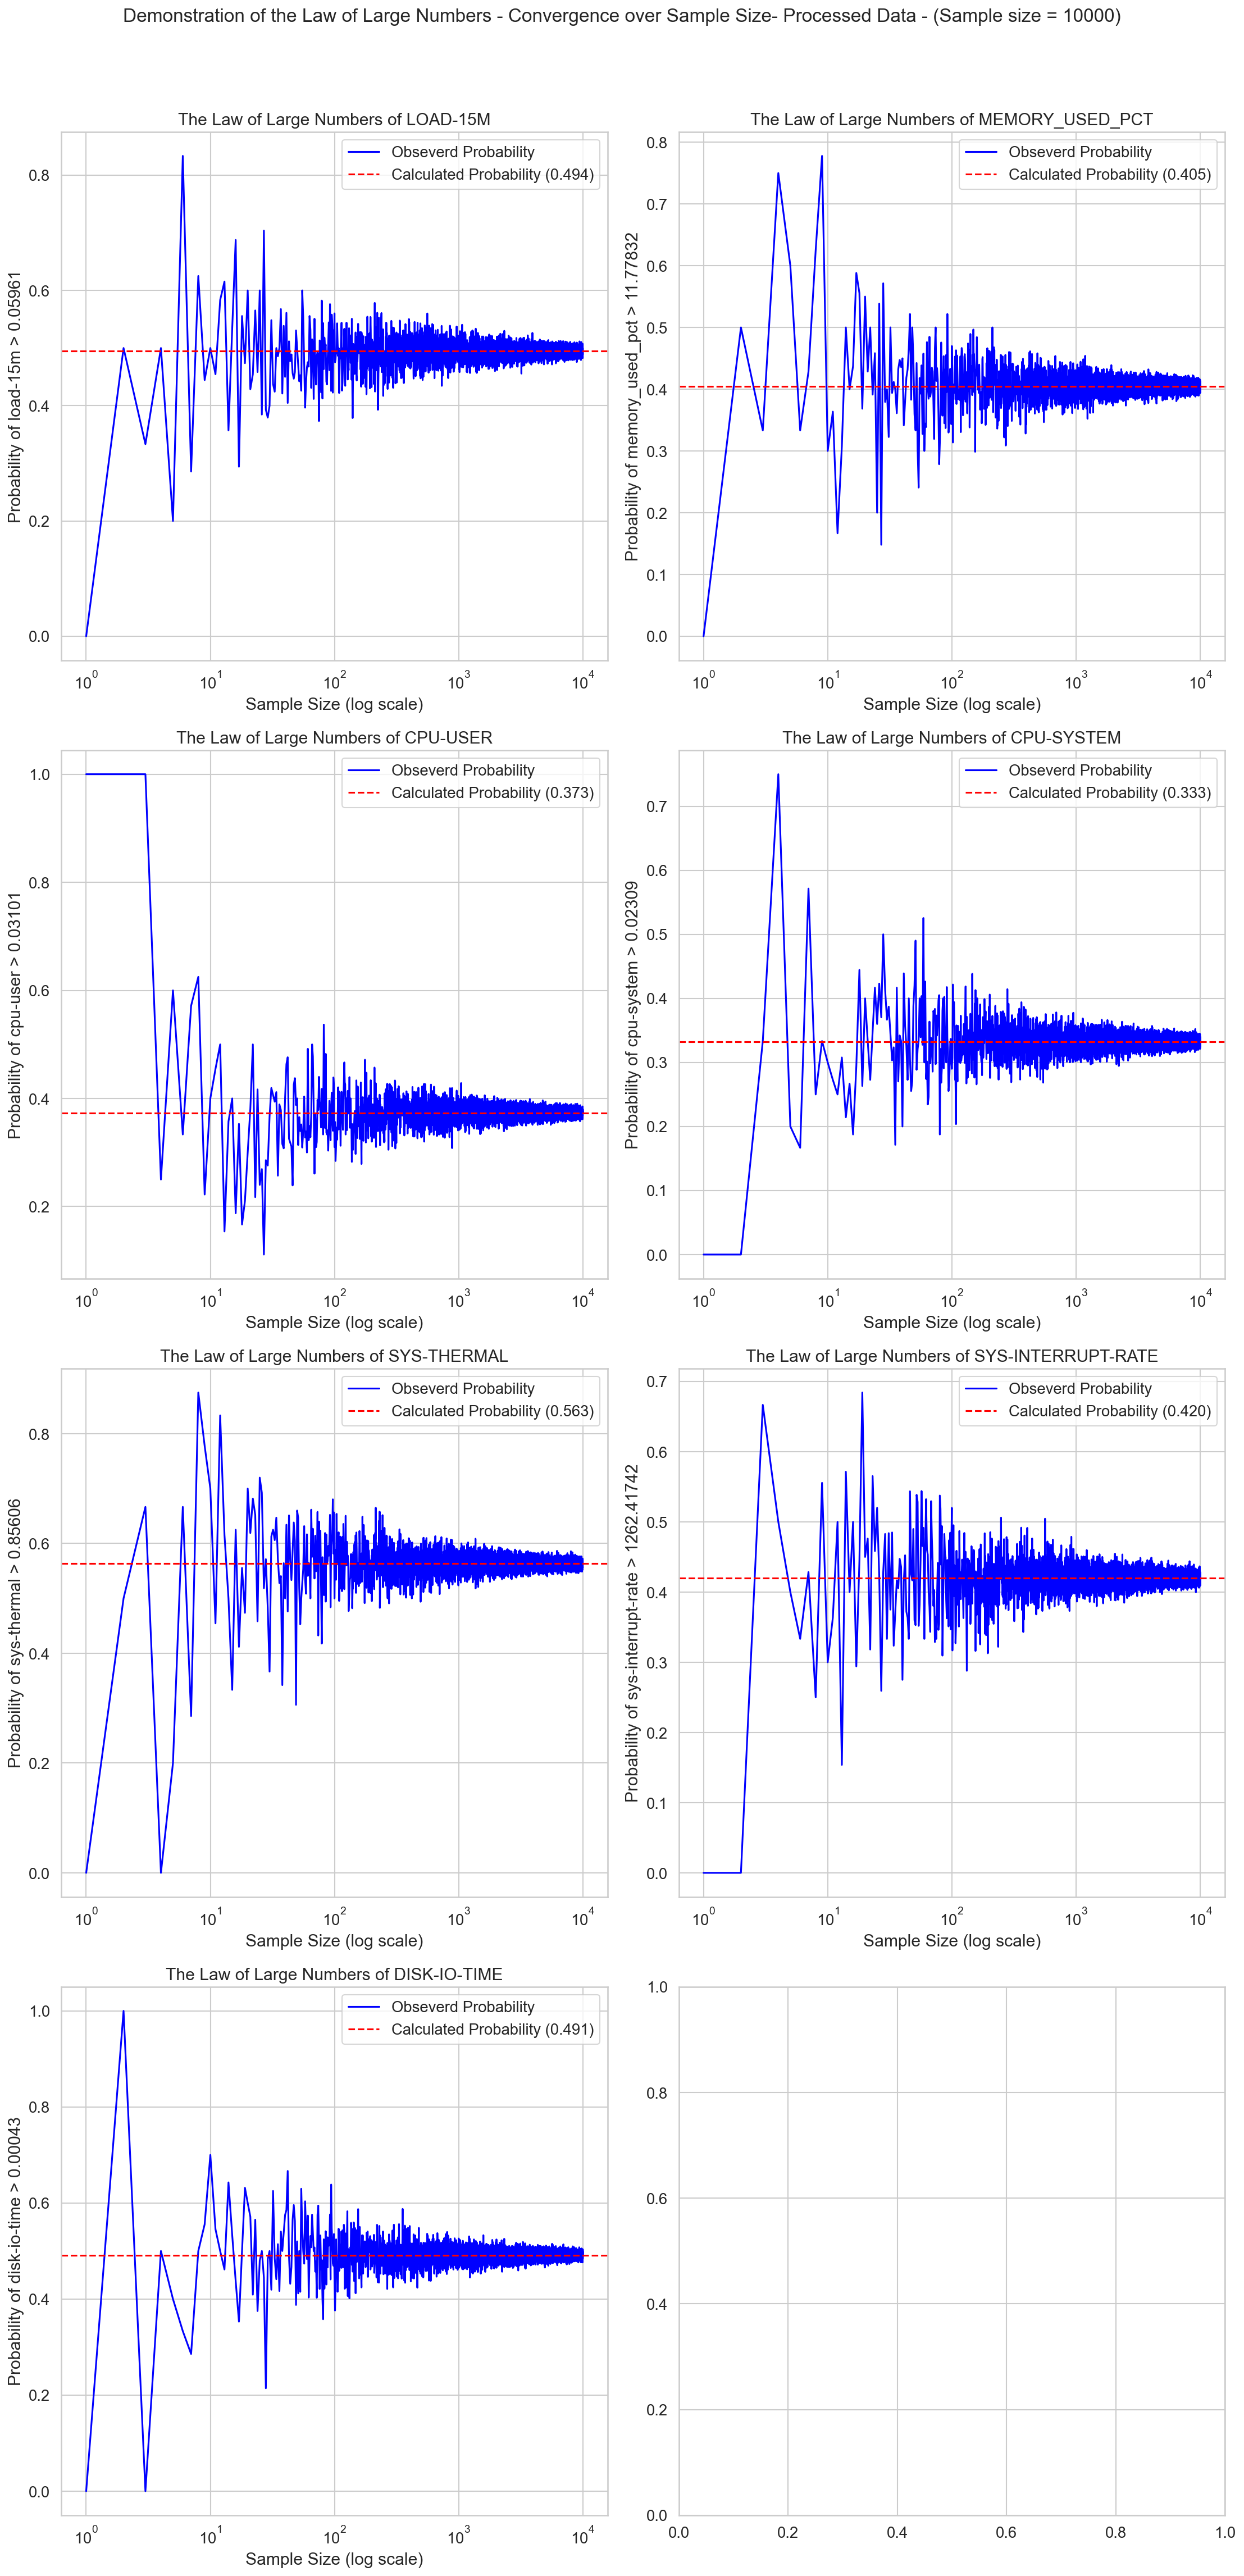

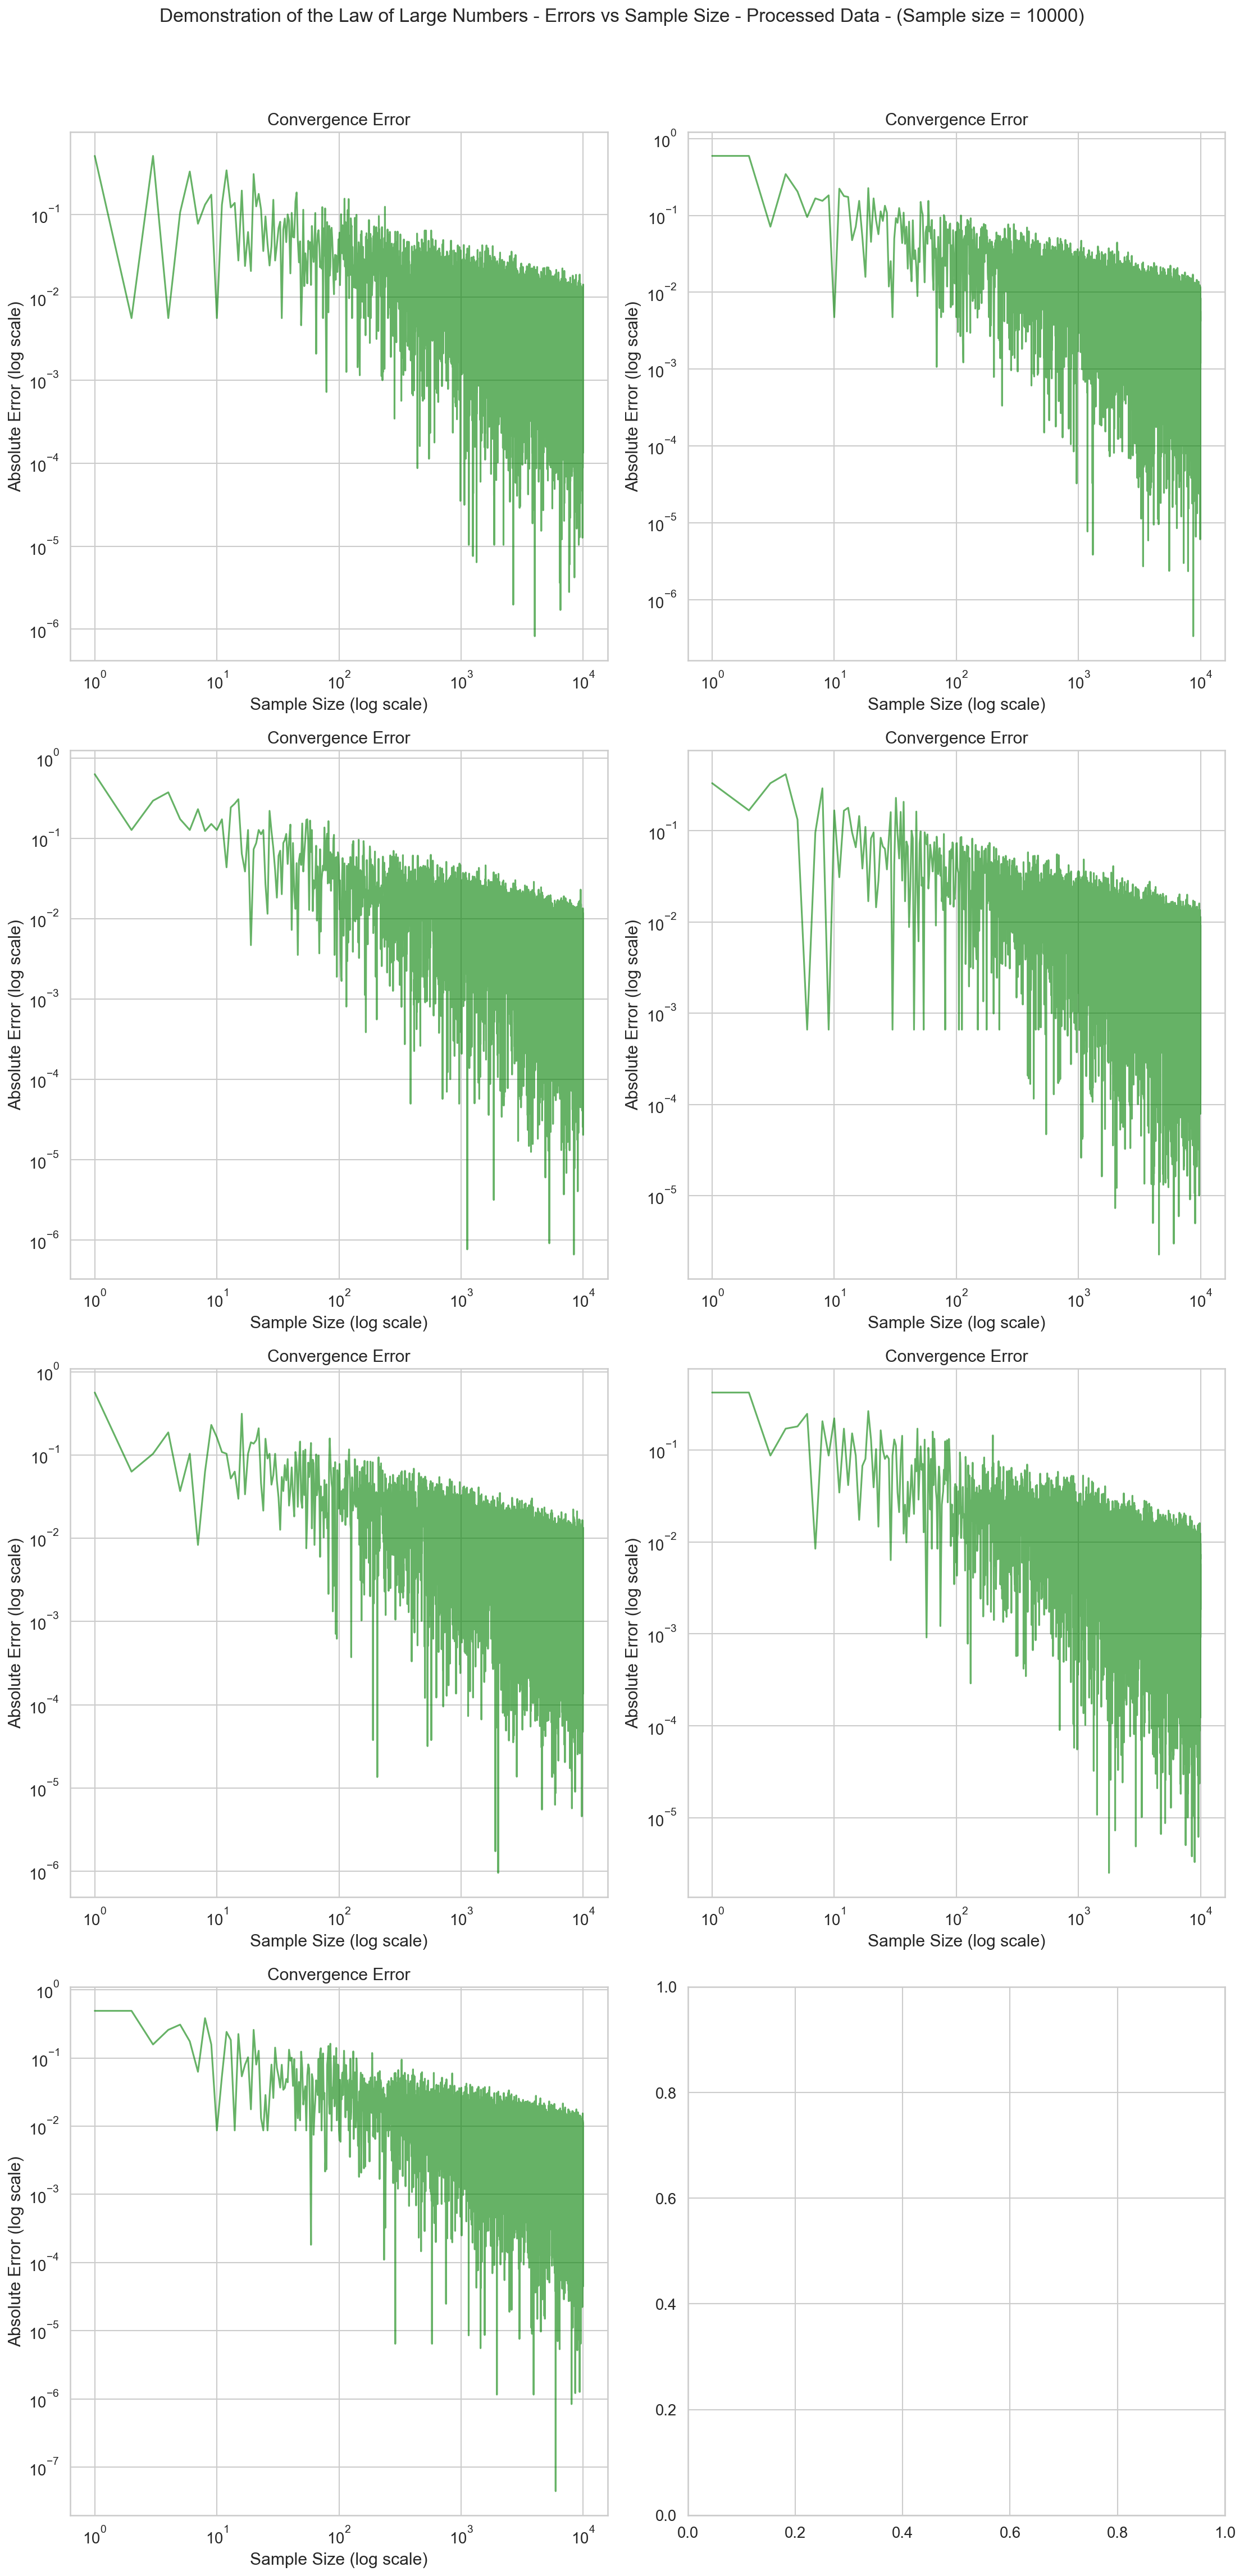

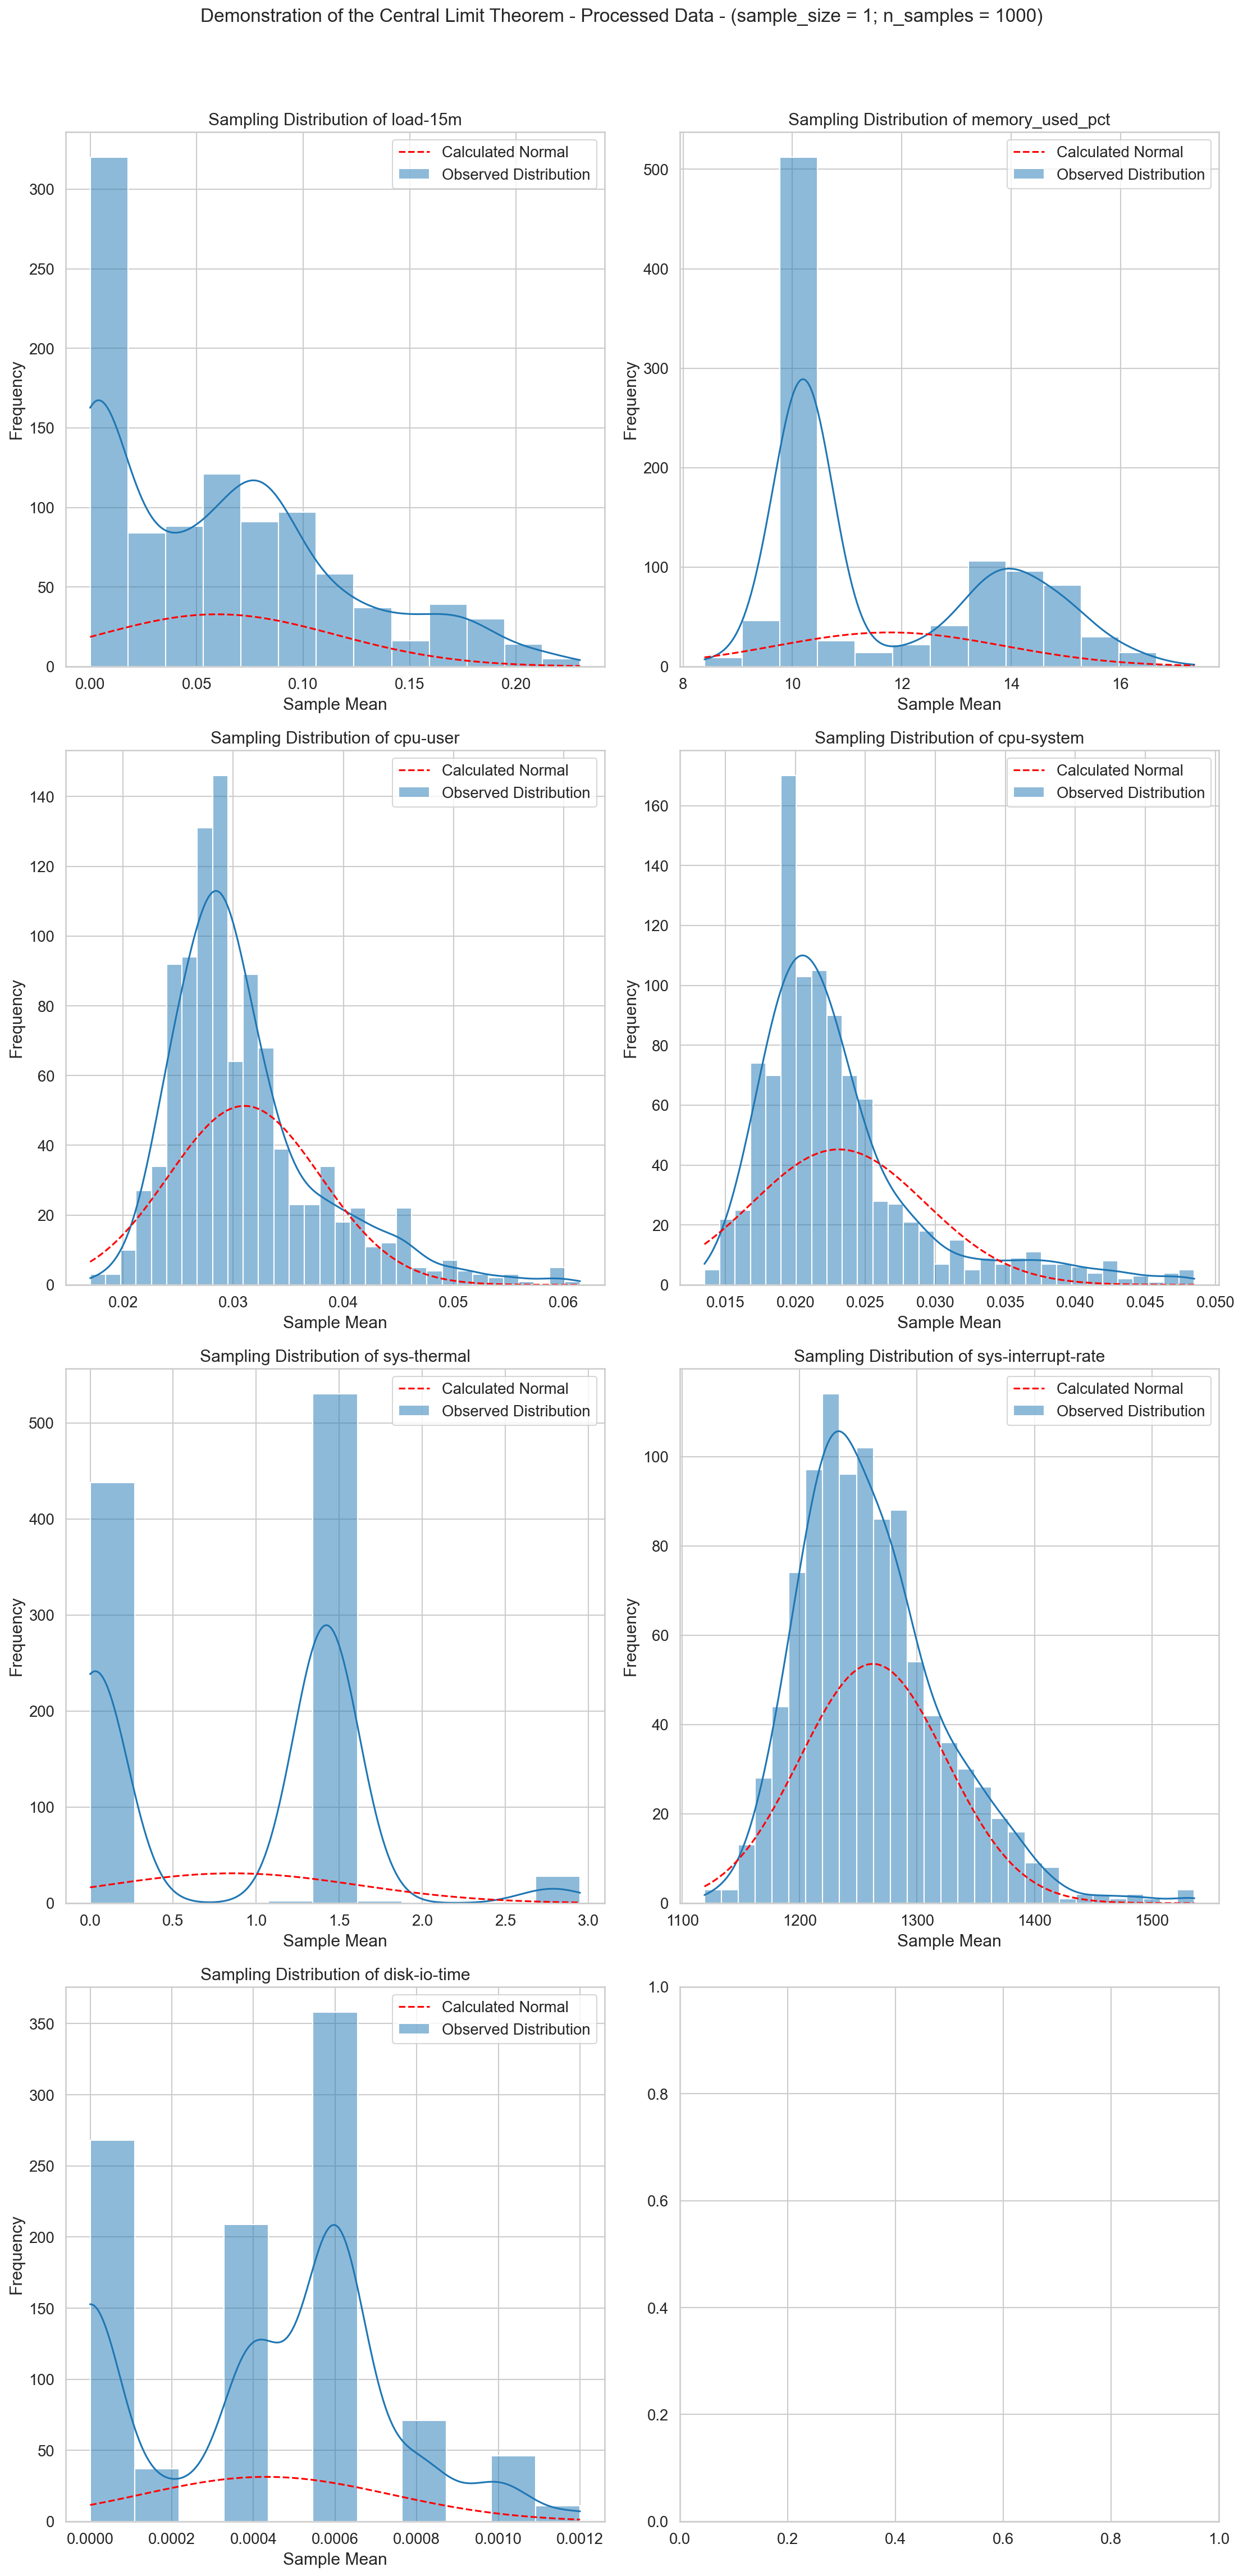

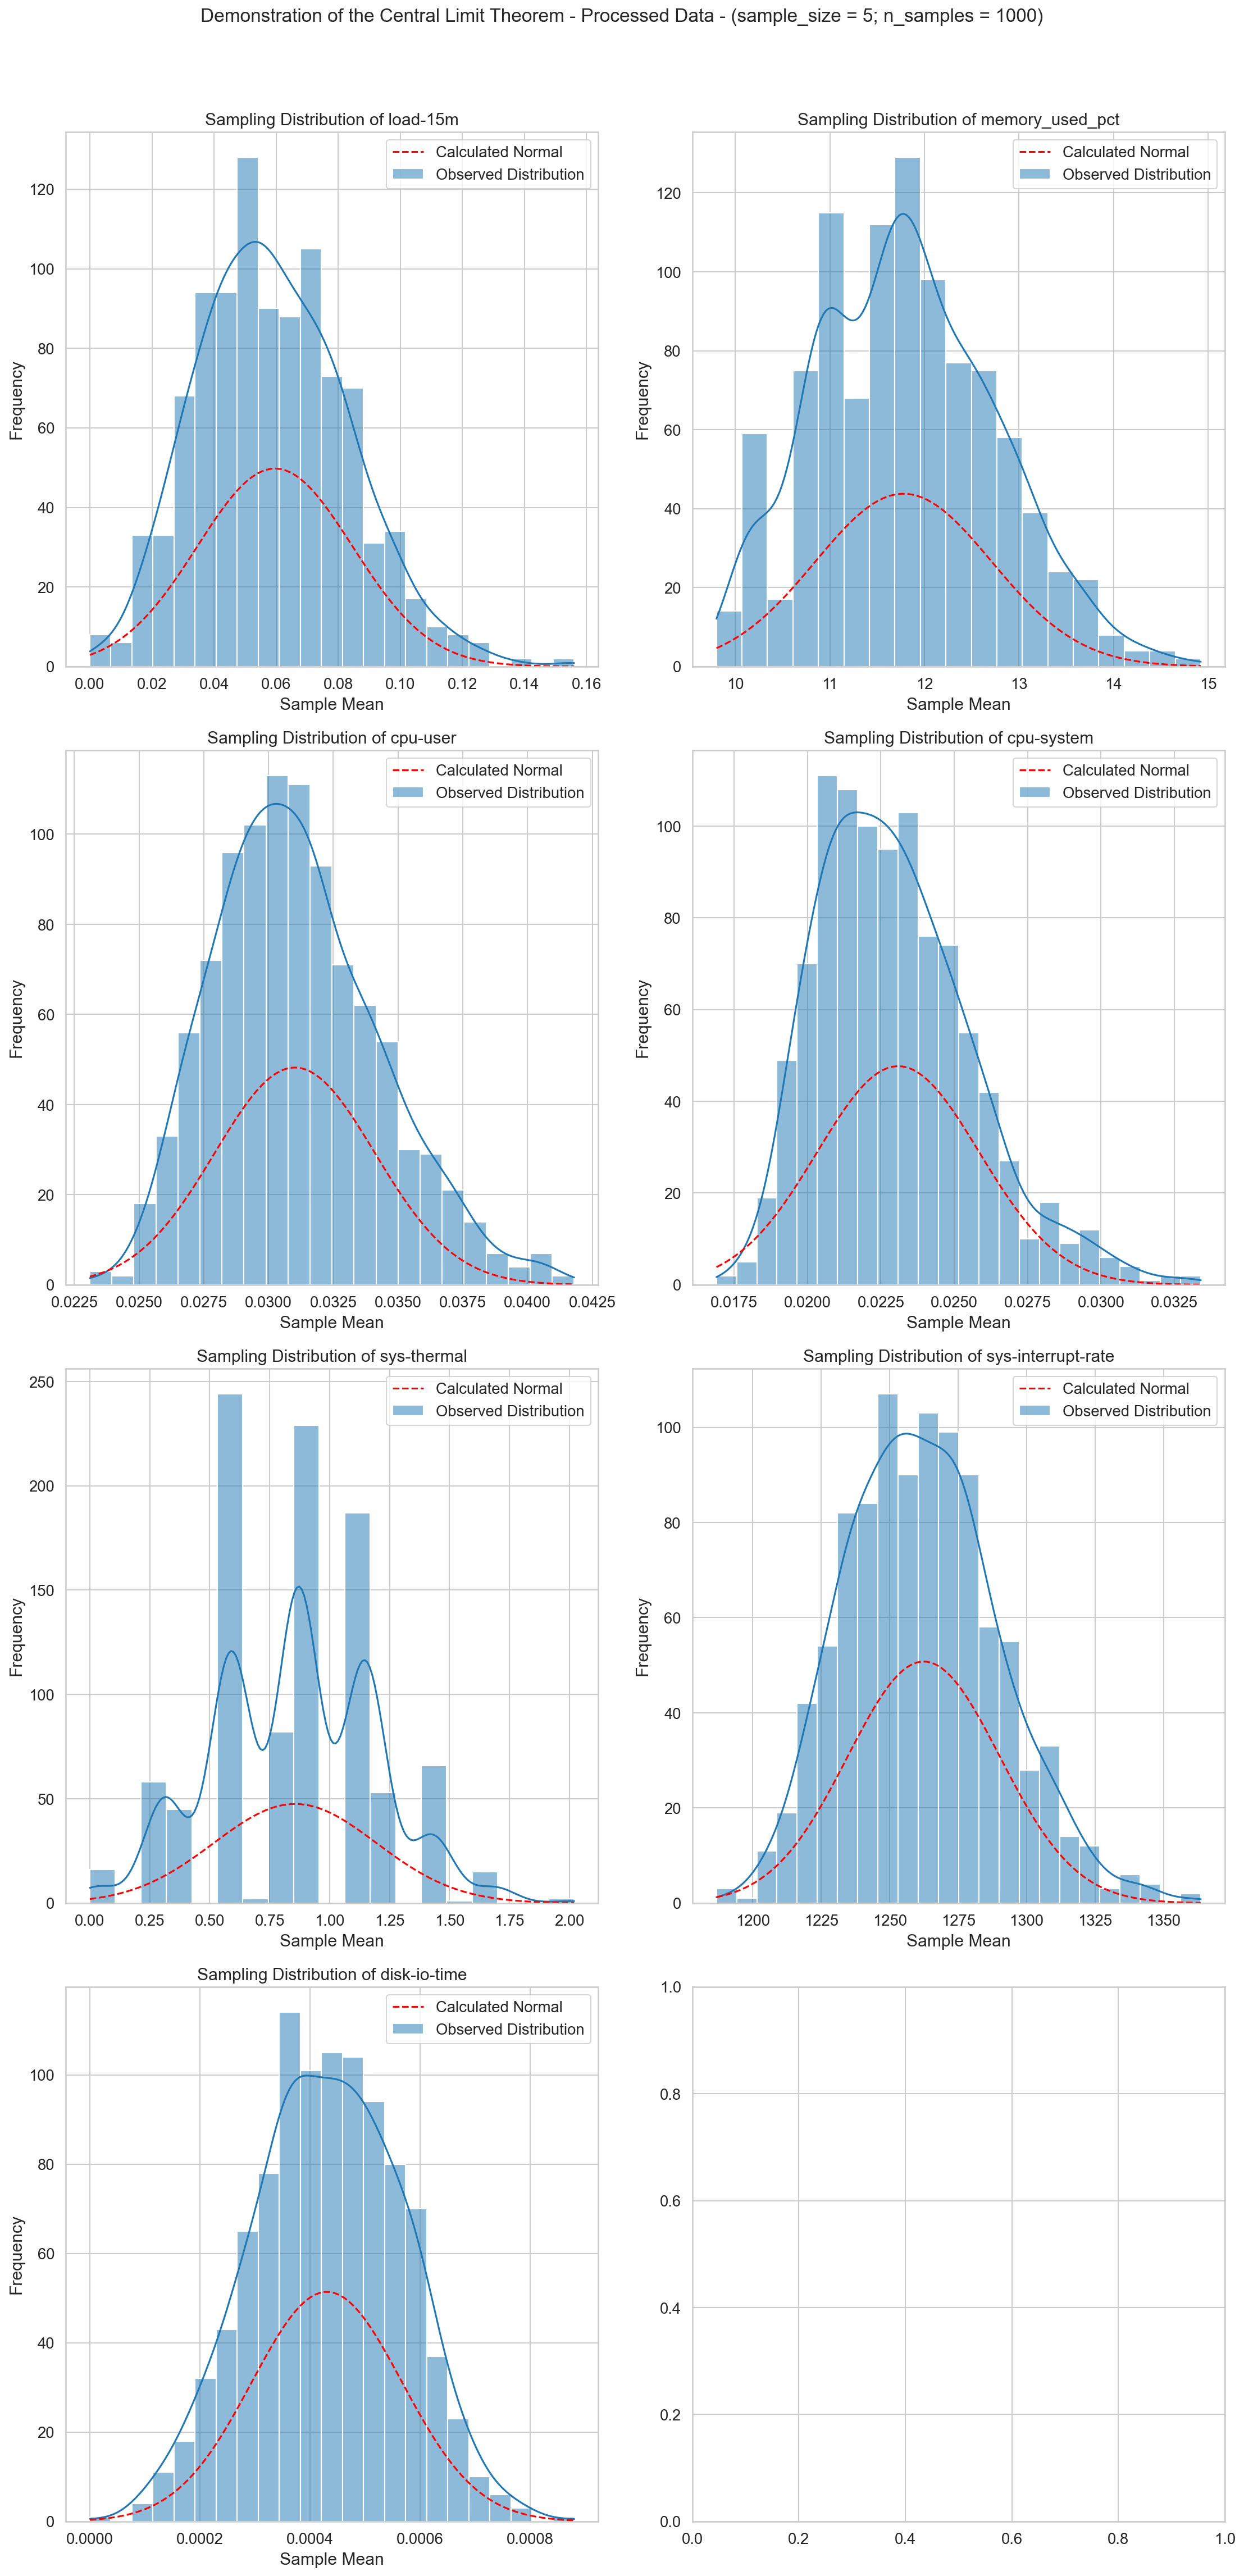

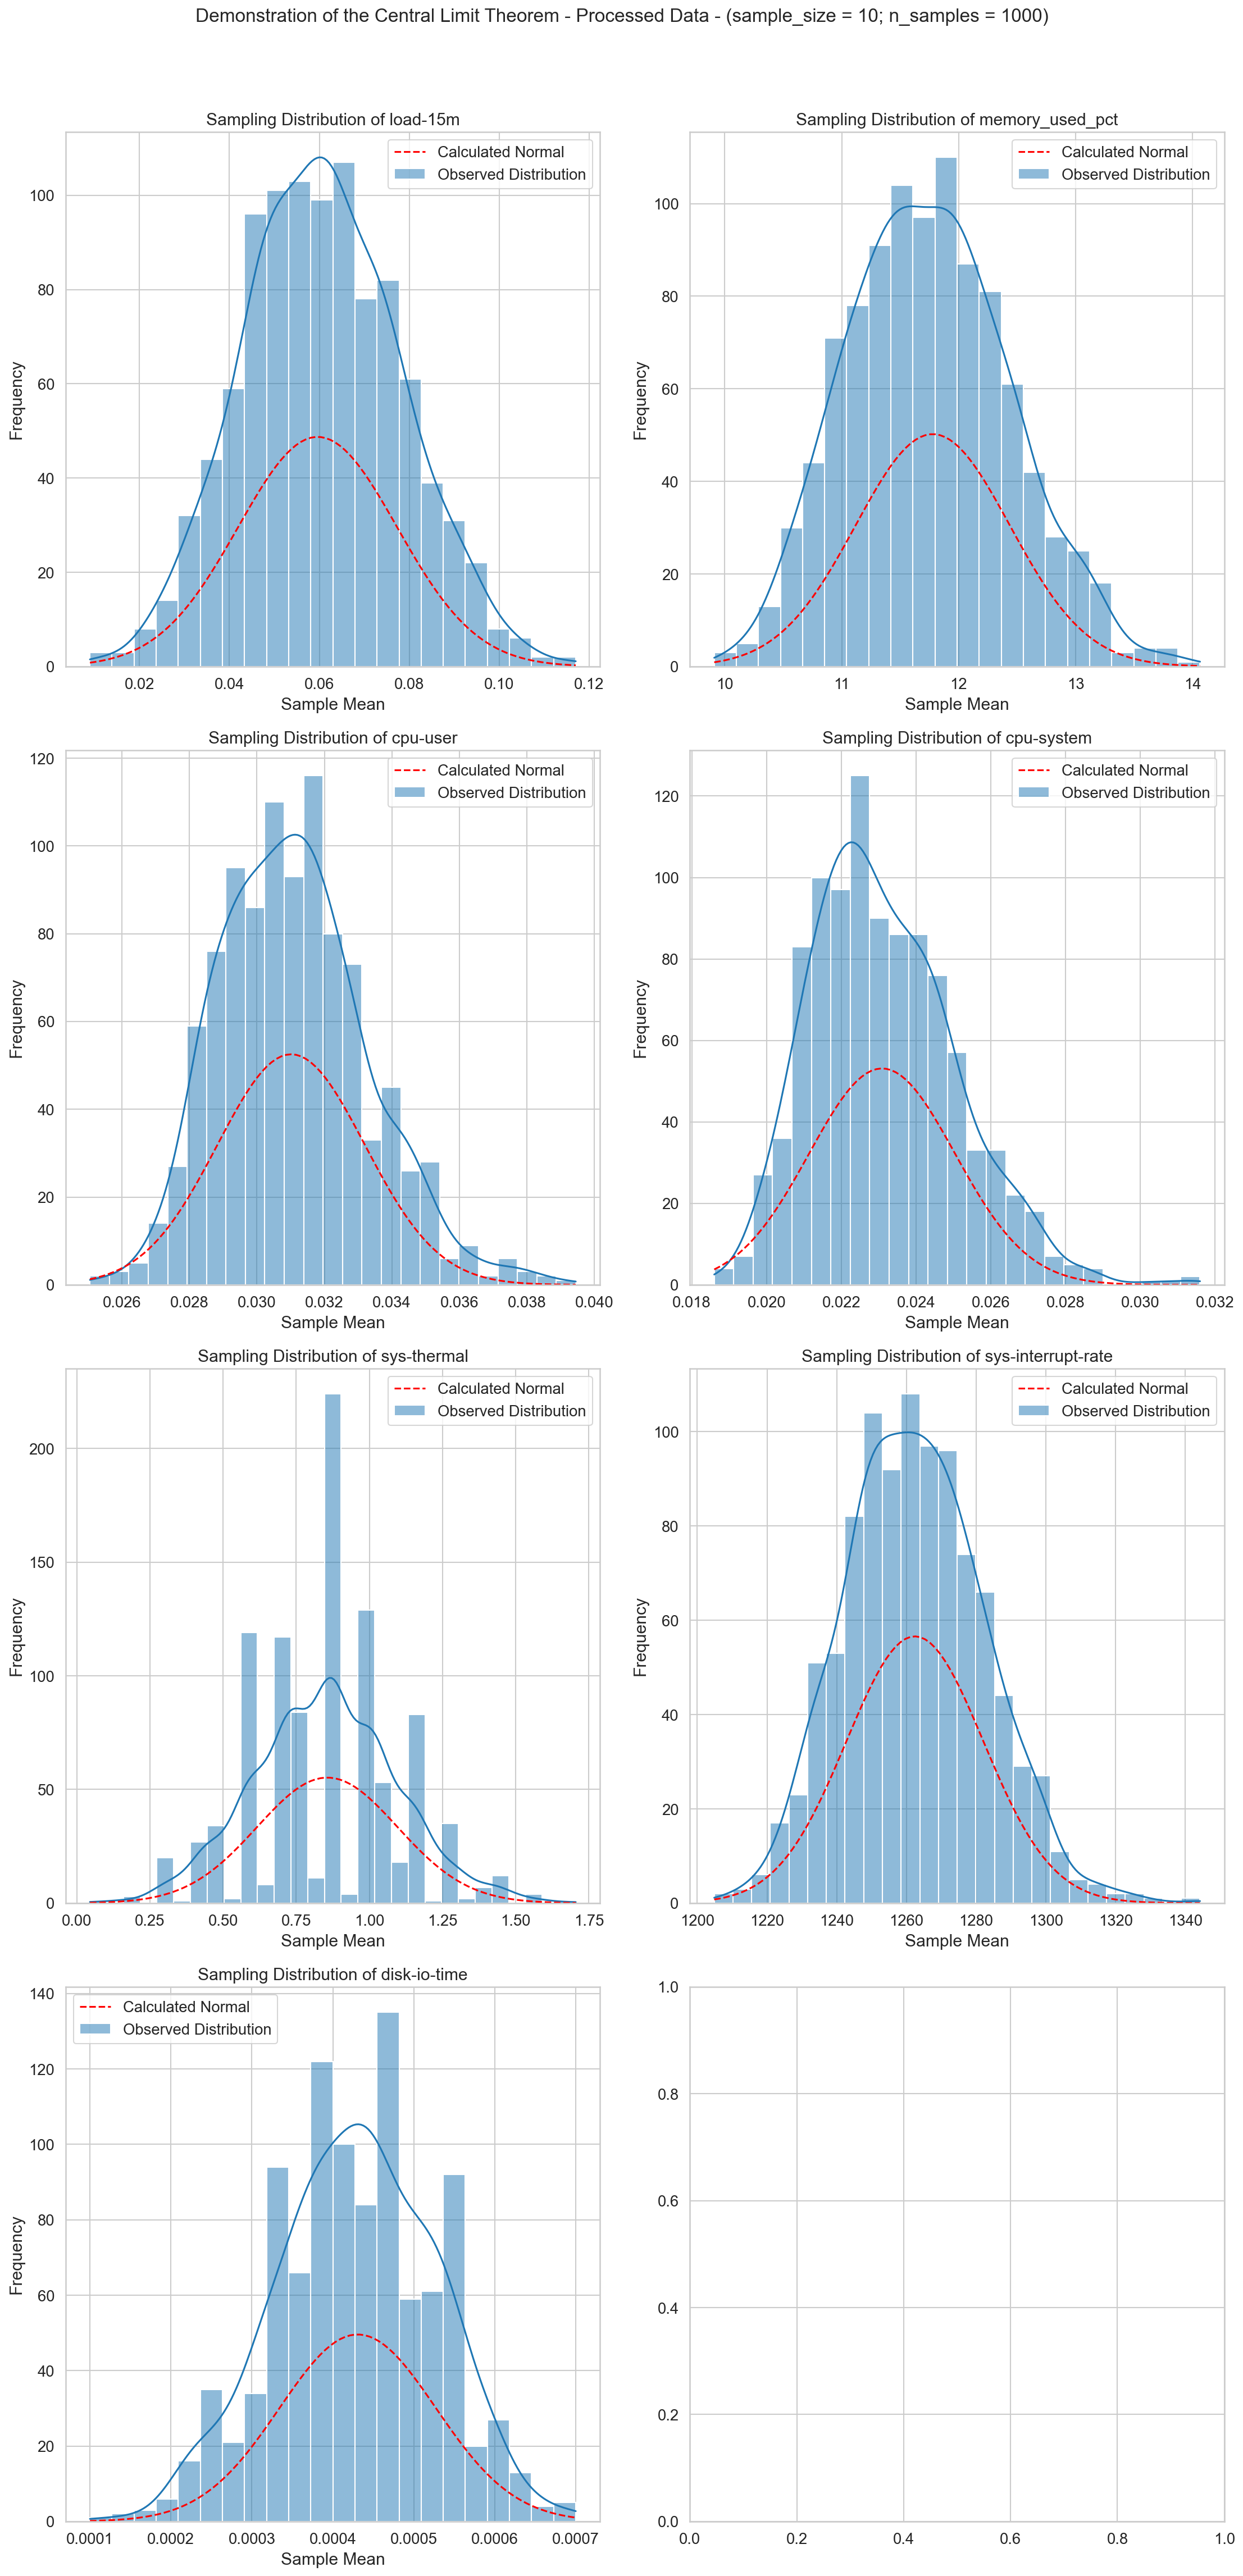

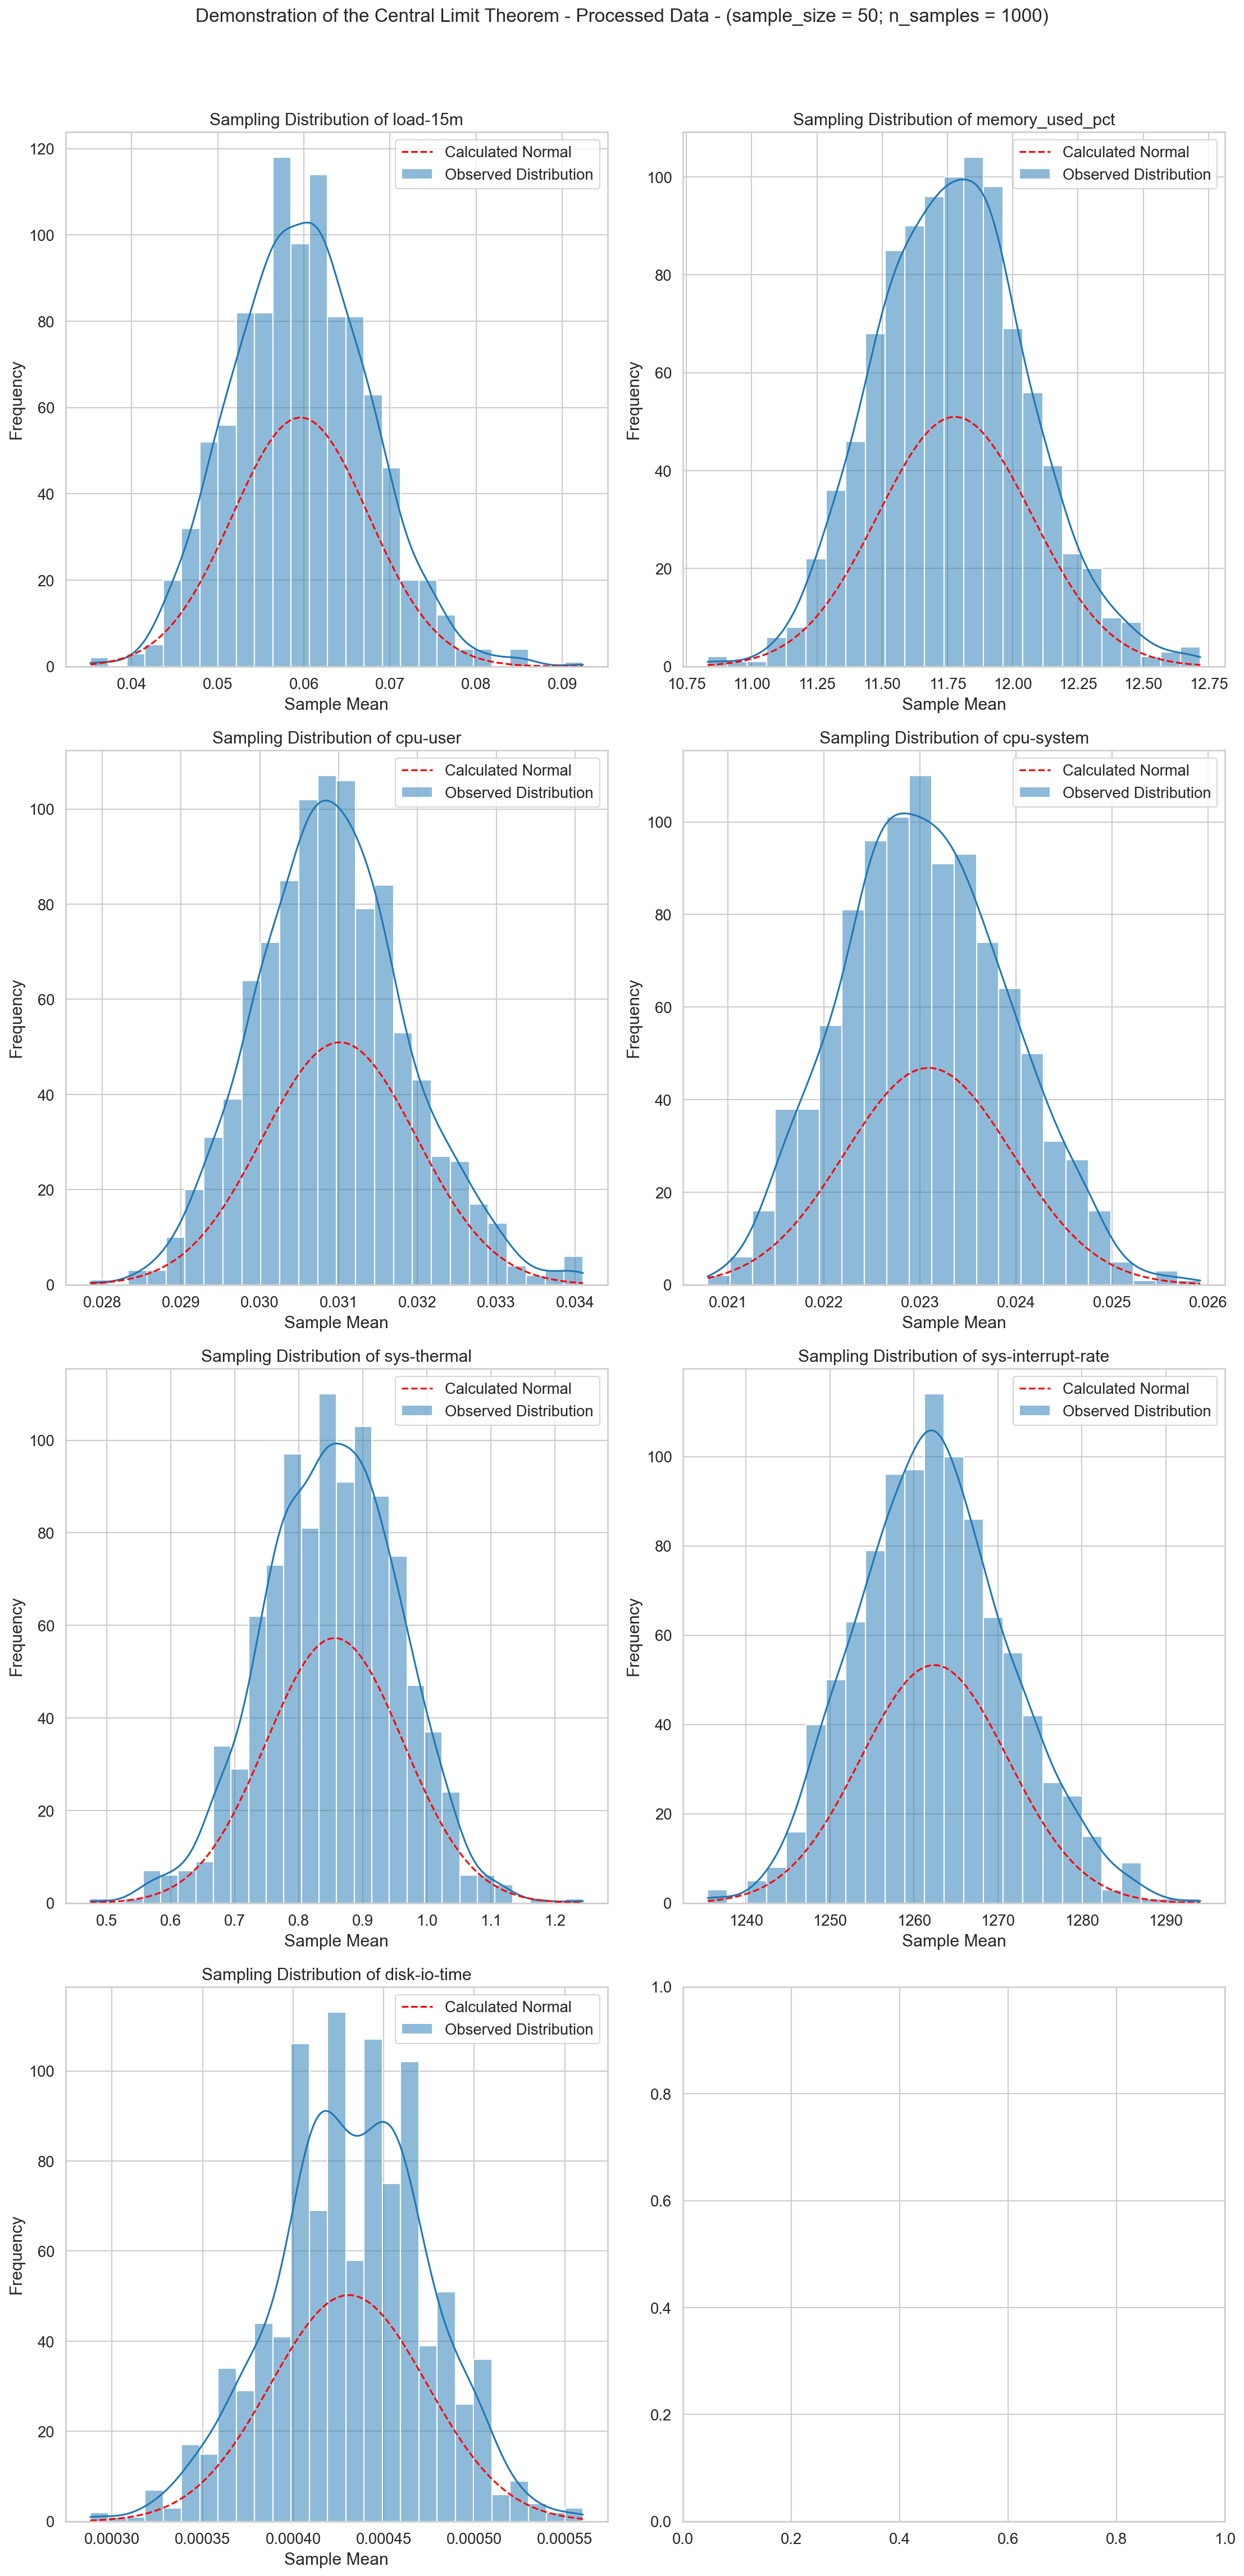

In [126]:
# Visualize the Statistical Theory
anylist = preprocess_system_data(False, pathFilter,file,None)
visualize_statistical_theory(True, anylist[1],anylist[2])

## 2.3 Regression Analysis
- **Linear/Polynomial model selection**
- **Model fitting and validation**
- **Result interpretation and analysis**
> ...

In [ ]:
#TODO